# Weather Data Exploration

### Introduction
This file is a playground for exploring data and trying out some data science concepts. The data is a mixture of sensor readings at the XNA airport from 2019 into August of 2022.

### Exploration Ideas
1. Perform EDA to thoroughly understand data
    - Get a broad sense for the dataset
    - Inspect individual variables for interest
    - Investigate covariance between variables
2. Use API to pull data at regular intervals.
3. Build a machine learning model and then test on live-streaming data pulled from API.
4. Build visualizations into a dashboard displayed on a webpage.
5. Build visualizations to demonstrate relationships between data.

### Observations
- Spent a lot of time investigating the weather conditions data to try to parse it into data usable for modeling. The text data is highly non-standard with fine differences between points. Also, there's <b>lots</b> of null values to contend with.
- Unmodified dataset contains monthly, daily, and hourly summaries. This analysis will limit scope to hourly predictions (which can be summarized to daily and monthly anyway)

## Analysis Code

### Imports

In [733]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects
import datetime as dt
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)


### Functions

In [640]:
def DropNaCols(df):
    '''given a dataframe, drop all the columns with nothing but NaN'''
    naColList = []
    for ele in df.columns:
        uniqueVals = list(df[ele].unique())
        if len(uniqueVals) == 1:
            naColList.append(ele)
    return(df.drop(columns=naColList))

In [641]:
def ReadingType(df):
    '''indicates whether the given row provides a monthly, daily, or hourly reading'''
    
    #get the different column types into separate lists
    monthlyCols = [ele for ele in list(df.columns) if 'month' in ele.lower()]
    dailyCols = [ele for ele in list(df.columns) if 'dai' in ele.lower()]
    hourlyCols = [ele for ele in list(df.columns) if 'hour' in ele.lower()]

    #create columns indicating whether a row contains monthly, daily, or hourly readings
    boolMask_monthly = ~df[monthlyCols].isna()
    df['monthlyInd'] = boolMask_monthly.sum(axis=1)

    boolMask_daily = ~df[dailyCols].isna()
    df['dailyInd'] = boolMask_daily.sum(axis=1)

    boolMask_hourly = ~df[hourlyCols].isna()
    df['hourlyInd'] = boolMask_hourly.sum(axis=1)

    #if a row has more than one non-NaN value in a monthly column, the reading is monthly, else if more than one non-NaN value in a daily column, the reading is daily, else if more than one non-Nan value in an hourly column, the reading is hourly else indicate no valid readings for the row
    df['ReadingType'] = ['monthly' if df.iloc[ele]['monthlyInd'] > 0 else 'daily' if df.iloc[ele]['dailyInd'] > 0 else 'hourly' if df.iloc[ele]['hourlyInd'] > 0 else 'noValidReading' for ele in range(df.shape[0])]

    return df

In [642]:
def SplitDataframes(df):
    '''given a dataframe of labeled monthly, daily, and hourly readings, split the dataframe by those labels into component dataframes and load those to a dictionary labeled according to reading type'''
    dfDict = {}
    for ele in df['ReadingType'].unique():
        dfDict[ele] = DropNaCols(df[df['ReadingType'] == ele]).reset_index(drop=True)
    return dfDict

In [643]:
def CleanWeatherDF(df):
    '''given a dataframe of local weather data, do some cosmetic cleaning including...
    1. remove uppercase from column names and add underscores between words
    2. convert date column to datetime'''

    #1. remove uppercase from column names and add underscores between words
    new_column_names = []
    for ele in list(df.columns):
        if ele.isupper():
            new_column_names.append(re.sub('([.])','_',ele.lower()))
        else:
            new_column_names.append(re.sub('([.])','_',re.sub('(?<!^)(?=[A-Z])', '_',ele).lower()))
    df.columns = new_column_names

    # convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    return df

In [644]:
#clean up numerican columns, converting strings to digits, removing unnecessary strings, converting to floats
def CleanHourlyColumns(df):
    '''given a dataframe of hourly weather values, clean up the column values'''
    numerical_columns = ['hourly_altimeter_setting','hourly_dew_point_temperature','hourly_dry_bulb_temperature','hourly_precipitation','hourly_pressure_change','hourly_pressure_tendency','hourly_relative_humidity','hourly_sea_level_pressure','hourly_station_pressure','hourly_visibility','hourly_wet_bulb_temperature','hourly_wind_direction','hourly_wind_gust_speed','hourly_wind_speed']

    for ele in numerical_columns:
        df[ele] = df[ele].replace('[A-Za-z*]','',regex=True).replace('',0).astype(float).fillna(0)

    return df

### Data Loading

In [706]:
#read in data
df = pd.read_csv('3063831.csv')

#add reading type column
df = ReadingType(df)

#clean up data
df = DropNaCols(df)

#next, put dataframe into separate dataframes depending on the type of reading
dfDict = SplitDataframes(df)

#clean up dataframes
for ele in dfDict.values():
    ele = CleanWeatherDF(ele)

#for numerical columns in the hourly data, make them truly numerical
dfDict['hourly'] = CleanHourlyColumns(dfDict['hourly'])

df = dfDict['hourly']
df = df.drop(['report_type','source','rem','report_type_1','source_1'],axis=1)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (21,27,28,29,30,31,36,37,38,42,43,49,50,52,54,57,59,60,61,62,64,115,118,120) have mixed types.Specify dtype option on import or set low_memory=False.



### Code that may again be useful

Parse current weather data into something categorical and analytical useful.

weather_au, weather_aw, weather_mw = [], [], []
notable_weather_present_mask = df['hourly_present_weather_type'].isna()
for ele in range(df.shape[0]):
    if notable_weather_present_mask[ele]:
        weather_au.append(['na'])
        weather_aw.append(['na'])
        weather_mw.append(['na'])
    else:
        ele_list = df['hourly_present_weather_type'][ele].split('|')
        weather_au.append(ele_list[0].strip().split(' '))
        weather_aw.append(ele_list[1].strip().split(' '))
        weather_mw.append(ele_list[2].strip().split(' '))

df['weather_au'], df['weather_aw'], df['weather_mw'] = weather_au, weather_aw, weather_mw

au_codes = {
    'DZ:01':'drizzle','RA:02':'rain','SN:03':'snow','SG:04':'snow grains','IC:05':'ice crystals','PL:06':'ice pellets','GR:07':'hail','GS:08':'small hail and/or snow pellets','UP:09':'unknown precipitation','BR:1':'mist','FG:2':'fog','FU:3':'smoke','VA:4':'volcanic ash','DU:5':'widespread dust','SA:6':'sand','HZ:7':'haze','PY:8':'spray','PO:1':'well develed dust/sand whirls','SQ:2':'squalls','FC:3':'funnel cloud, waterspout, or tornado','SS:4':'sandstorm','DS:5':'duststorm','na':'no reading'
}

au_code_modifiers = {
    '-':'light','+':'heavy','VC':'vicinity','MI':'shallow','PR':'partial','BC':'patches','DR':'low drifting','BL':'blowing', 'SH':'showers','TS':'thunderstorm','FZ':'freezingñ'
}

### EDA

In [707]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42079 entries, 0 to 42078
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          42079 non-null  datetime64[ns]
 1   hourly_altimeter_setting      42079 non-null  float64       
 2   hourly_dew_point_temperature  42079 non-null  float64       
 3   hourly_dry_bulb_temperature   42079 non-null  float64       
 4   hourly_precipitation          42079 non-null  float64       
 5   hourly_present_weather_type   10024 non-null  object        
 6   hourly_pressure_change        42079 non-null  float64       
 7   hourly_pressure_tendency      42079 non-null  float64       
 8   hourly_relative_humidity      42079 non-null  float64       
 9   hourly_sea_level_pressure     42079 non-null  float64       
 10  hourly_sky_conditions         41655 non-null  object        
 11  hourly_station_pressure     

In [692]:
df.describe()

,source,hourly_altimeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_pressure_change,hourly_pressure_tendency,hourly_relative_humidity,hourly_sea_level_pressure,hourly_station_pressure,hourly_visibility,hourly_wet_bulb_temperature,hourly_wind_direction,hourly_wind_gust_speed,hourly_wind_speed,source_1,hourly_ind
count,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000,42079.000000
mean,6.929894,29.955772,48.003398,57.772143,0.012294,0.000078,1.071009,72.600775,22.608688,28.275991,8.676638,51.991635,157.096889,3.581406,8.156658,6.929894,12.415837
std,0.311891,1.480493,17.737861,18.377616,0.067585,0.019676,2.314180,19.270098,12.950344,3.143012,2.735899,17.207038,111.884585,9.238910,19.566589,0.311891,1.407490
min,4.000000,0.000000,-17.000000,-13.000000,0.000000,-0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,0.000000,0.000000,0.000000,4.000000,1.000000
25%,7.000000,29.920000,34.000000,44.000000,0.000000,0.000000,0.000000,60.000000,29.500000,28.510000,10.000000,39.000000,50.000000,0.000000,5.000000,7.000000,12.000000
50%,7.000000,30.030000,51.000000,60.000000,0.000000,0.000000,0.000000,78.000000,29.950000,28.630000,10.000000,54.000000,170.000000,0.000000,7.000000,7.000000,12.000000
75%,7.000000,30.130000,64.000000,72.000000,0.000000,0.000000,0.000000,88.000000,30.090000,28.720000,10.000000,67.000000,230.000000,0.000000,11.000000,7.000000,14.000000
max,7.000000,30.700000,77.000000,106.000000,2.080000,0.180000,9.000000,100.000000,30.730000,29.270000,10.000000,80.000000,360.000000,66.000000,2237.000000,7.000000,16.000000


<AxesSubplot:>

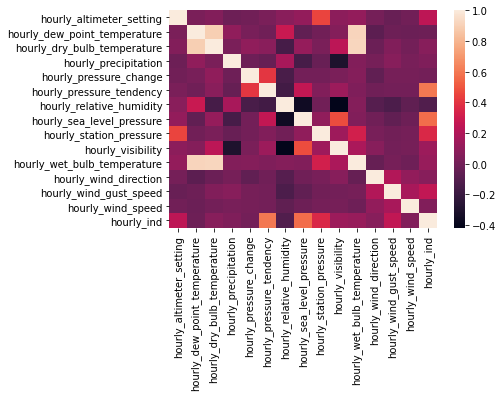

In [736]:
sns.heatmap(df.corr())

In [714]:
print('There are ',df.duplicated().sum(),' duplicated rows in the dataset.')

There are  0  duplicated rows in the dataset.


In [717]:
df.isnull().sum()

date                                0
hourly_altimeter_setting            0
hourly_dew_point_temperature        0
hourly_dry_bulb_temperature         0
hourly_precipitation                0
hourly_present_weather_type     32055
hourly_pressure_change              0
hourly_pressure_tendency            0
hourly_relative_humidity            0
hourly_sea_level_pressure           0
hourly_sky_conditions             424
hourly_station_pressure             0
hourly_visibility                   0
hourly_wet_bulb_temperature         0
hourly_wind_direction               0
hourly_wind_gust_speed              0
hourly_wind_speed                   0
hourly_ind                          0
dtype: int64

Conditions data has a lot of null values. Will avoid working with these data components; specific weather prediction is a little beyond the scope of this work for now as well. This has been noted in Observations section above.

In [730]:
if 'ellen has to pee':
    print('then she should pee')
else: print('if she doesn\'t have to then she should not')

then she should pee


In [726]:
df[df['hourly_precipitation']!=0]

,date,hourly_altimeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_present_weather_type,hourly_pressure_change,hourly_pressure_tendency,hourly_relative_humidity,hourly_sea_level_pressure,hourly_sky_conditions,hourly_station_pressure,hourly_visibility,hourly_wet_bulb_temperature,hourly_wind_direction,hourly_wind_gust_speed,hourly_wind_speed,hourly_ind
60,2019-01-02 14:46:00,30.15,26.0,31.0,0.01,-FZ:8 RA:02 |FZRA |,0.00,0.0,82.0,0.00,OVC:08 5,28.74,4.0,29.0,310.0,0.0,3.0,12
61,2019-01-02 14:53:00,30.15,26.0,31.0,0.01,NaN,0.08,6.0,82.0,30.17,OVC:08 5,28.74,6.0,29.0,310.0,0.0,3.0,14
71,2019-01-02 20:13:00,30.14,29.0,34.0,0.01,-FZ:8 RA:02 |FZRA |,0.00,0.0,82.0,0.00,SCT:04 5 OVC:08 48,28.73,6.0,32.0,300.0,0.0,3.0,12
72,2019-01-02 20:25:00,30.14,29.0,34.0,0.01,-FZ:8 RA:02 |FZRA |,0.00,0.0,82.0,0.00,BKN:07 5 OVC:08 48,28.73,5.0,32.0,310.0,0.0,3.0,12
73,2019-01-02 20:53:00,30.14,29.0,34.0,0.05,-FZ:8 RA:02 |FZRA |,-0.00,3.0,82.0,30.16,BKN:07 5 OVC:08 49,28.73,3.0,32.0,290.0,0.0,3.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42000,2022-08-21 05:07:00,30.05,68.0,69.0,0.13,TS:7 RA:02 BR:1 |RA TS |RA,0.00,0.0,96.0,0.00,SCT:04 32 BKN:07 44 OVC:08 85,28.64,4.0,68.0,320.0,16.0,3.0,13
42001,2022-08-21 05:28:00,30.03,68.0,69.0,0.15,VCTS:7 -RA:02 |RA |RA,0.00,0.0,96.0,0.00,FEW:02 55 BKN:07 90 OVC:08 110,28.63,9.0,68.0,100.0,0.0,6.0,12
42002,2022-08-21 05:46:00,30.04,68.0,70.0,0.15,-RA:02 |RA |RA,0.00,0.0,93.0,0.00,FEW:02 90 BKN:07 110,28.64,10.0,69.0,0.0,0.0,0.0,12
42003,2022-08-21 05:53:00,30.06,68.0,69.0,0.06,-RA:02 |RA |RA,-0.04,1.0,96.0,30.01,SCT:04 90 OVC:08 110,28.66,10.0,68.0,170.0,0.0,6.0,15


In [683]:
#monthly precipitation graph
group = df.groupby([df['date'].dt.year,df['date'].dt.month])['hourly_precipitation'].sum().rename_axis(index=['Year','Month']).reset_index()
group['main'] = group['Year'].astype(str) + '-' +  group['Month'].astype(str)
px.line(group,x='Month',y='hourly_precipitation',color='Year')